In [96]:
from scipy.special import logsumexp
from sklearn.cluster import KMeans
from scipy.special import logsumexp
import sys

class EM:
    p = None
    dim = None # dimension of the data space
    n_points = None # Number of data points
    n_clusters = None # Number of clusters
    pi = None # The prior probability vector of pi_j values
    nnz = None
    p_spread = .99 # the probability weight
    X = None # the data
    q_all = [sys.maxsize]
    
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        return
    
    # private method
    # initialize p and pi using KMeans
    def initialize(self):
        
        self.p = 1.0/self.dim * np.ones((self.n_clusters, self.dim))
        self.pi = 1.0/self.n_clusters * np.ones(self.n_clusters)
        
        km = KMeans(n_clusters=self.n_clusters)
        km.fit(self.X)
        clusters = km.labels_
        
        for j in range(self.n_clusters):
            cluster_points = self.X[clusters == j, :]
            self.pi[j] = cluster_points.shape[0] / self.n_points
            
            dist = np.sum(cluster_points, 0)
            p_j = dist * self.p_spread / np.sum(dist)
            zero_count = (p_j == 0).sum()
            p_j[p_j == 0] = (1 - self.p_spread)/zero_count
            
            self.p[j] = p_j
                            
        return
    
    def fit(self, X):
        self.n_points = X.shape[0]
        self.dim = X.shape[1]
        self.X = X
        self.initialize();
        
        i = 1
        while i < 10:
            w = self.e_step()
            self.m_step(w)
            if (abs(self.q_all[-1] - self.q_all[-2]) < 0.0001):
                break
            i = i + 1
            
        return
    
    def e_step(self):
        log_lik = self.X.dot(np.log(self.p).T) + np.log(self.pi)
        
        w = np.exp((log_lik.T - logsumexp(log_lik)).T)
        q = np.sum(log_lik*w)
        self.q_all.append(q)
        return w
    
    def m_step(self, w):
        for j in range(self.n_clusters):
            numerator = np.sum(np.multiply(self.X.T, w[:,j]).T, 0)
            denominator = np.sum(np.sum(self.X, 1) * w[:,j])
            self.p[j,] = (numerator + 0.0001)/(denominator + (0.0001 * self.dim))

        self.pi = np.sum(w, 0)/ self.n_points        
        return
        

In [97]:
# Load the data
nips_data = np.loadtxt('docword.nips.txt', skiprows=3, dtype=int)
X = np.zeros(shape=(1500, 12419))

# Prepare X
for row in nips_data:
    X[row[0]-1][row[1] -1] = row[2]

em = EM(n_clusters=30)
em.fit(X)

In [98]:
em.q_all

[9223372036854775807,
 -17.110548200208726,
 -14.159131935227233,
 -12.375752310396914,
 -11.915633451910793,
 -11.400434839103657,
 -10.909927900455559,
 -10.331614799197895,
 -9.8133063108147756,
 -9.7026645875194628]

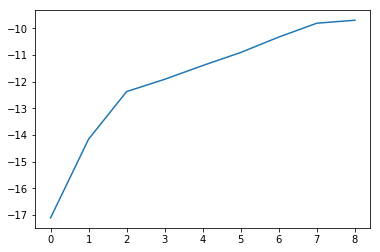

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(em.q_all[1:])

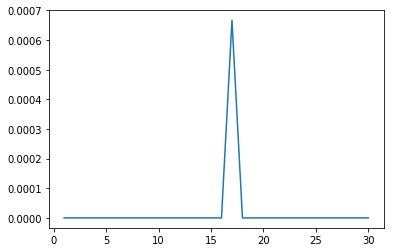

In [100]:
plt.plot([i for i in range(1,31)], em.pi)

In [102]:
em.pi.sum()

0.00066666666666666643